VAE_CNN_GRU Latent Space간의 차이 해석하기

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""

import tensorflow as tf
from src import vrae, train, utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

[]


# Data Load

In [2]:
def tensorset(arr, shape, batch_size, drop_remainder=True):
    # type casting & reshaping
    data = arr.astype(np.float32)
    print("Before reshape : {}".format(data.shape))
    data = np.reshape(data, shape)
    print("After reshape : {} | data type : {}".format(data.shape, data.dtype))
    # make to tensor
    ds = tf.data.Dataset.from_tensor_slices(data)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    return ds

In [3]:
batch_size = 128
train_set_arr = np.load('/works/Data/wellysis/preprocessed/5s_mit_forVAEtrain.npy')
print("Total Data Set shape is : {}".format(train_set_arr.shape))
time_size = train_set_arr.shape[1]
print(train_set_arr.min(), train_set_arr.max(), train_set_arr.mean(), train_set_arr.std())
train_set_tensor = tensorset(arr = train_set_arr, shape=(-1, time_size, 1), batch_size=batch_size)

Total Data Set shape is : (225408, 640, 1)
0.0 1.0 0.48390256368532036 0.07240195371434505
Before reshape : (225408, 640, 1)
After reshape : (225408, 640, 1) | data type : float32


# Model Load

In [4]:
from src import vae_cnn_gru

model = vae_cnn_gru.VAE_CNNGRU(T=640, hidden_size=512, latent_dims=8, dropout=0.0, recurrent_dropout=0.0, reparam=False)
model.summary()

Model: "DARNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 640, 1)]     0                                            
__________________________________________________________________________________________________
Encoder_Module (Functional)     (None, 512)          4122432     inputs[0][0]                     
__________________________________________________________________________________________________
EncoderTransLayer (EncoderTrans ((None, 8), (None, 8 8208        Encoder_Module[0][0]             
__________________________________________________________________________________________________
LatentLayer (LatentLayer)       (None, 8)            0           EncoderTransLayer[0][0]          
                                                                 EncoderTransLayer[0][1]      

In [5]:
model.load_weights("/works/GitLab/jomjam/Python/AnomalyDetection/ECG/save/20210901_09_04_19_5s_mitTotal_vae_cnn_gru_512hidden_8latent_gauss_kld1e4_bat128_lr1e4/save")

# Reconstruction Check

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

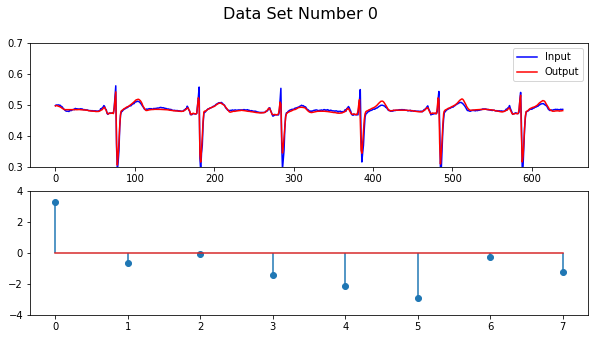

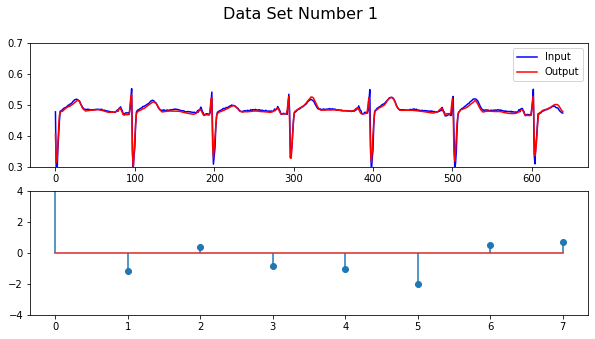

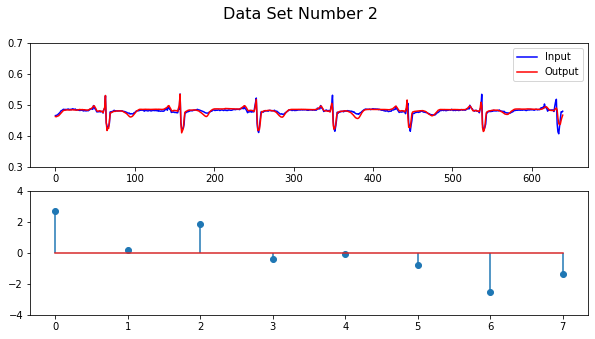

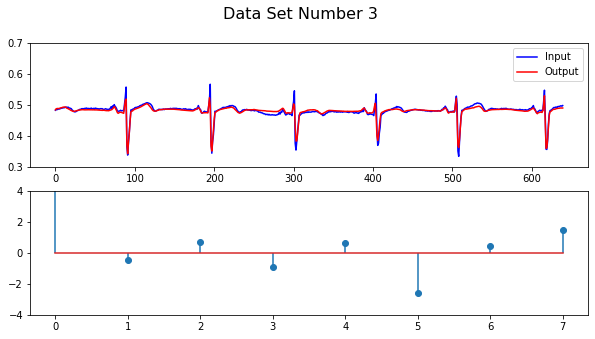

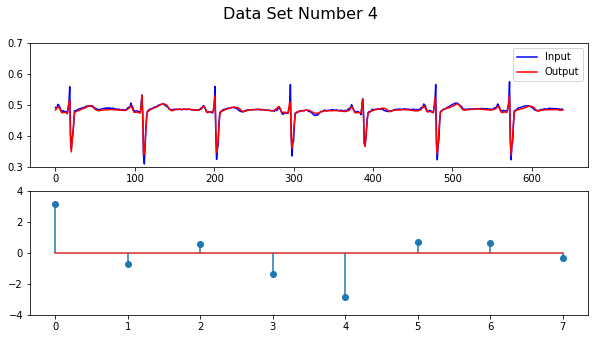

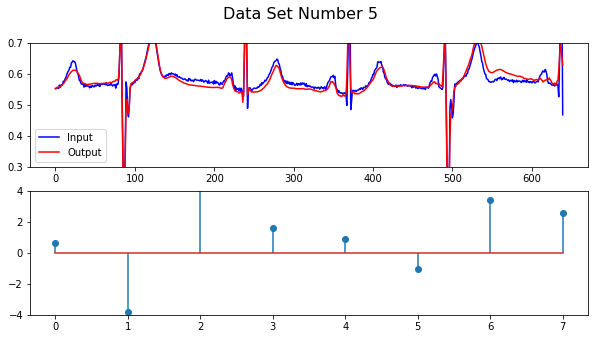

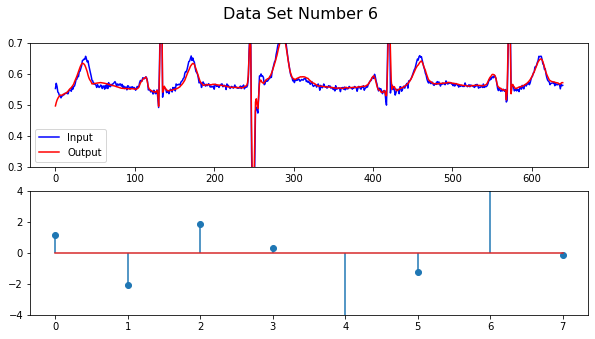

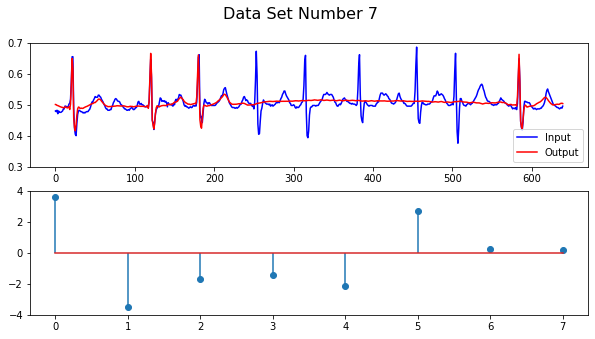

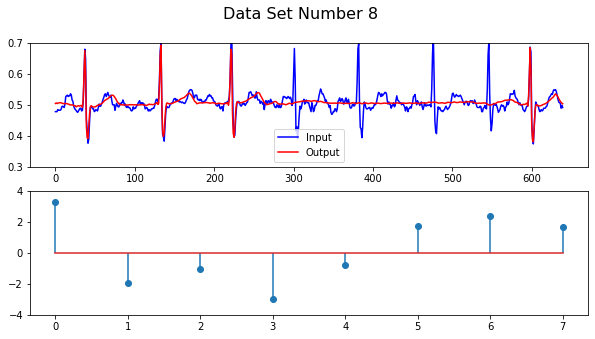

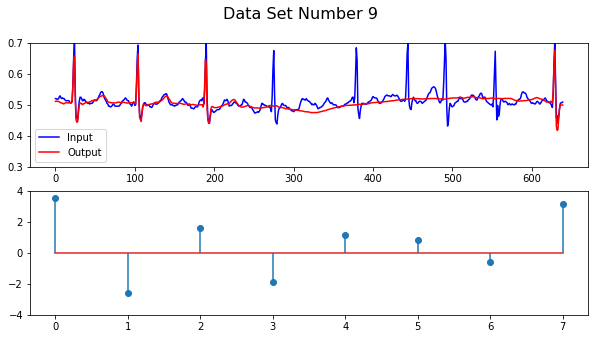

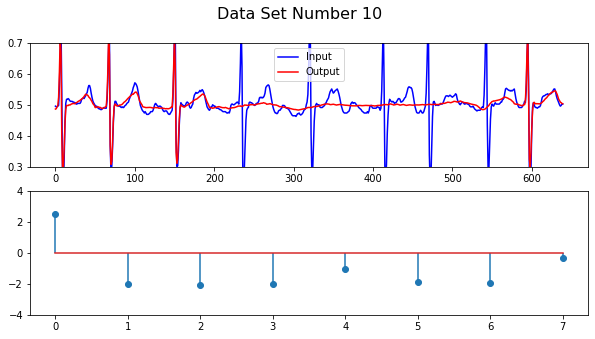

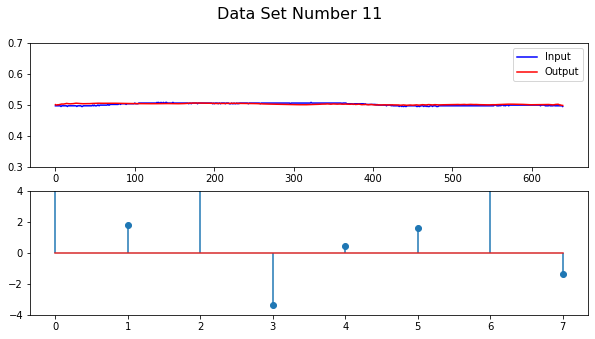

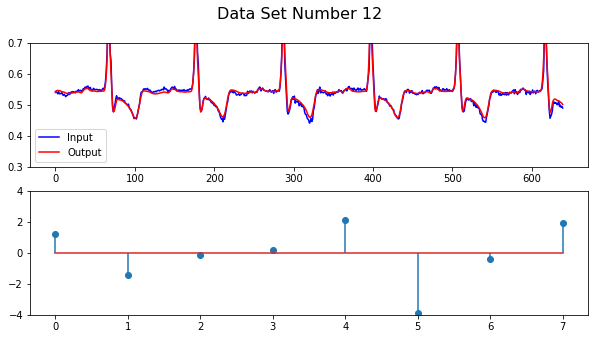

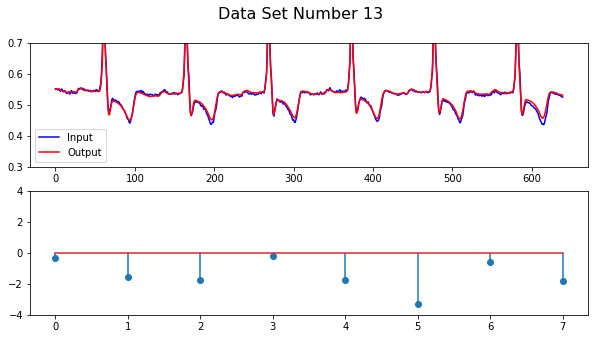

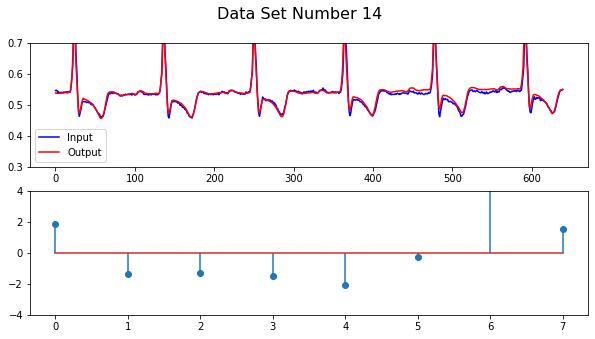

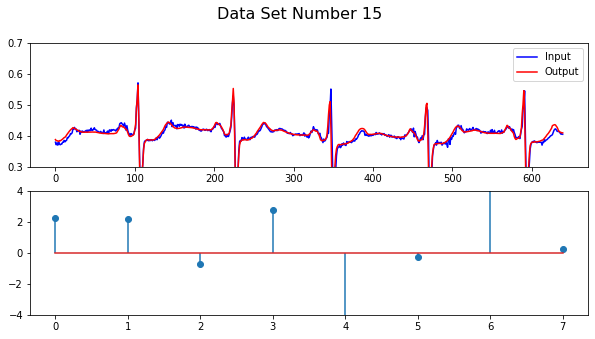

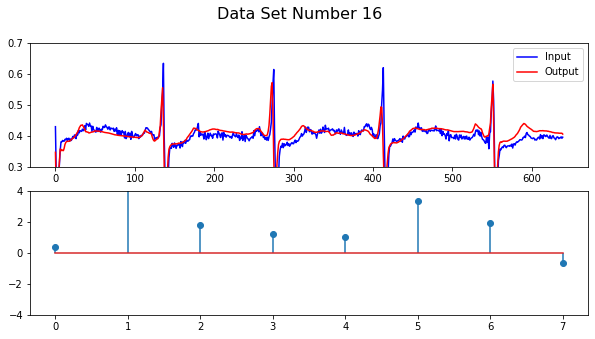

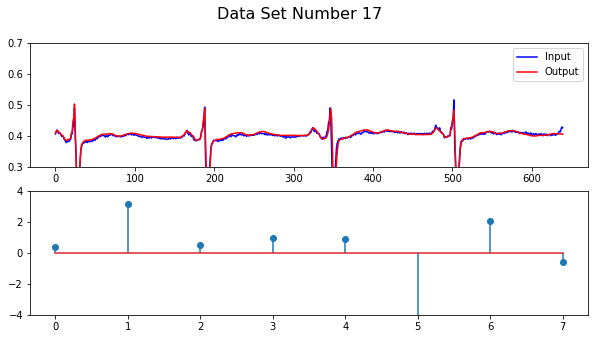

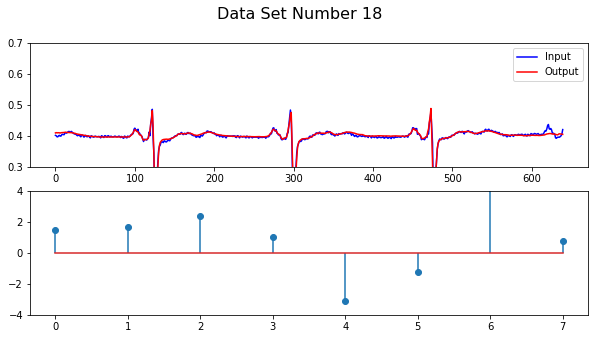

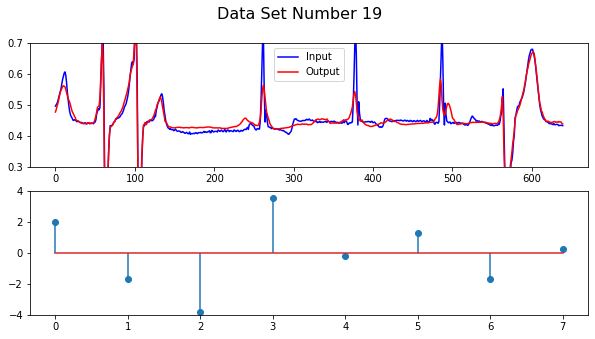

(20, 640, 1)


In [7]:
show_num = 20
show_idx = 0

sample_arr_list = []


for arr in train_set_arr[::10000]:
    sample_arr_list.append(arr)
    tens = tf.convert_to_tensor(arr.reshape(1,640,1), dtype=tf.float32)
    outputs, latents, _ = model(tens)
    
    real = arr.reshape(-1)
    pred = outputs.numpy().reshape(-1)
    late = latents.numpy().reshape(-1)
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    ax.plot(np.arange(time_size), real, label="Input", color="b")
    ax.plot(np.arange(time_size), pred, label="Output", color="r")
    ax.set(ylim=(0.3, 0.7))
    ax.legend()
    
    ax2.stem(late)
    ax2.set(ylim=(-4, 4))
    fig.suptitle('Data Set Number {}'.format(show_idx), fontsize=16)
    plt.show()
    show_idx+=1
    if show_idx == show_num:
        break
        
sample_arr = np.array(sample_arr_list)
print(sample_arr.shape)

# Clustering

In [11]:
def make_latent_set(model, data_set):
    base_arr = np.zeros((1, 8), dtype=np.float32)
    for x in data_set:
        outputs, latent, _ = model(x)
        latent_arr = latent.numpy()
        base_arr = np.concatenate((base_arr, latent_arr), axis=0)
    base_arr = base_arr[1:]
    print(base_arr.shape)
    return base_arr

In [12]:
total_data_latent_arr = make_latent_set(model, train_set_tensor)

(225408, 8)


In [13]:
from sklearn.cluster import KMeans

In [14]:
kmeans_latent = KMeans(n_clusters=10).fit(total_data_latent_arr)
print(np.unique(kmeans_latent.labels_))
print(len(kmeans_latent.labels_))
for_see = np.load('/works/Data/wellysis/preprocessed/5s_mit_forVAEtrain.npy')[:len(total_data_latent_arr)]
print(for_see.shape)

[0 1 2 3 4 5 6 7 8 9]
225408
(225408, 640, 1)


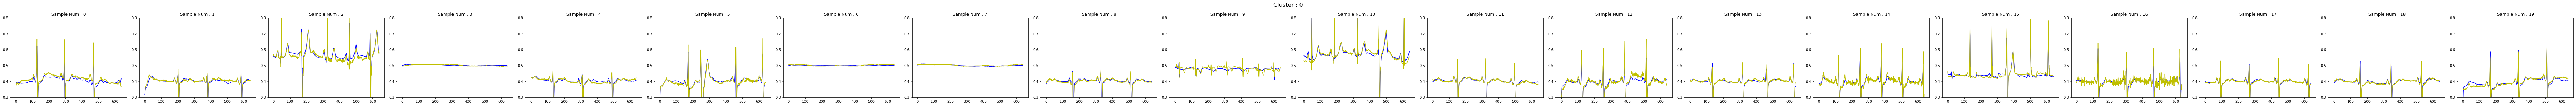

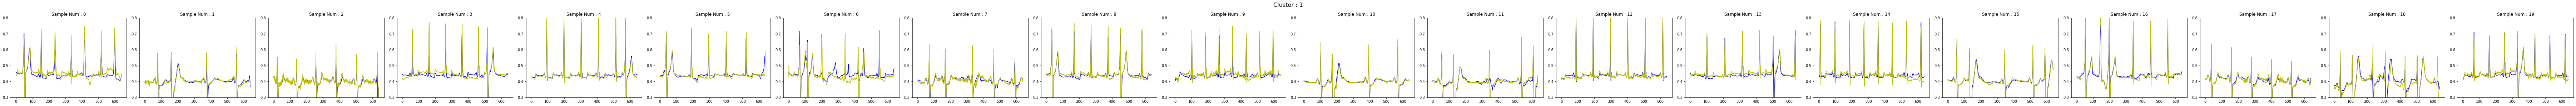

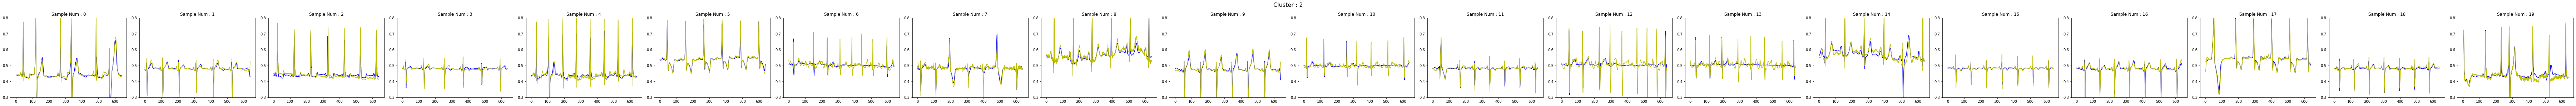

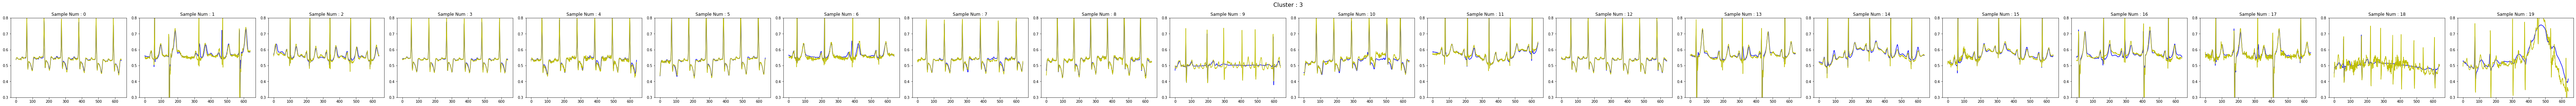

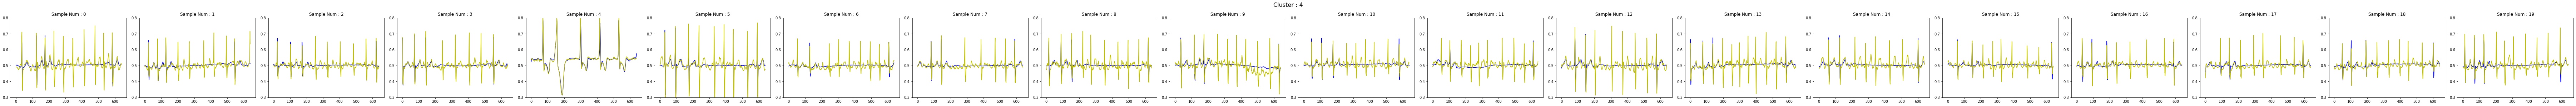

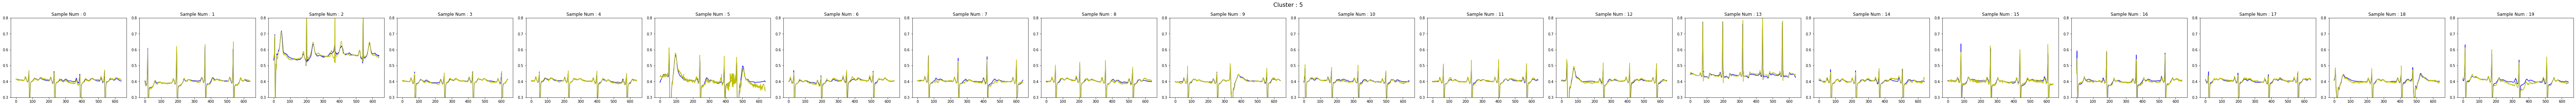

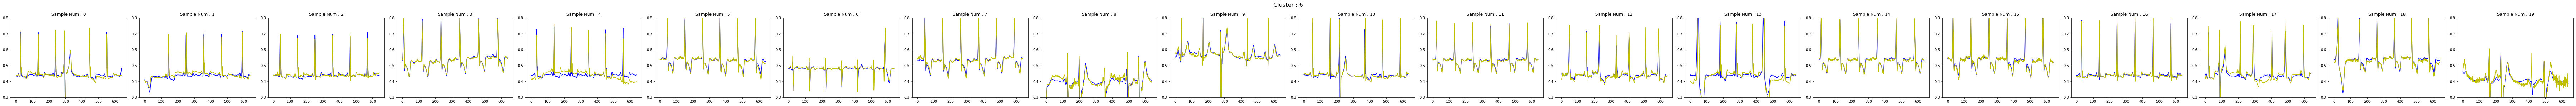

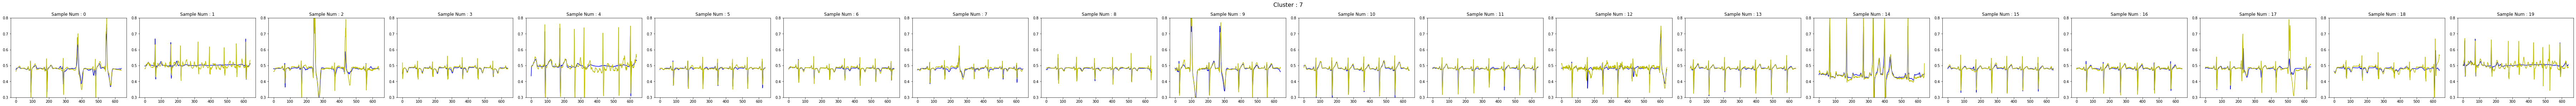

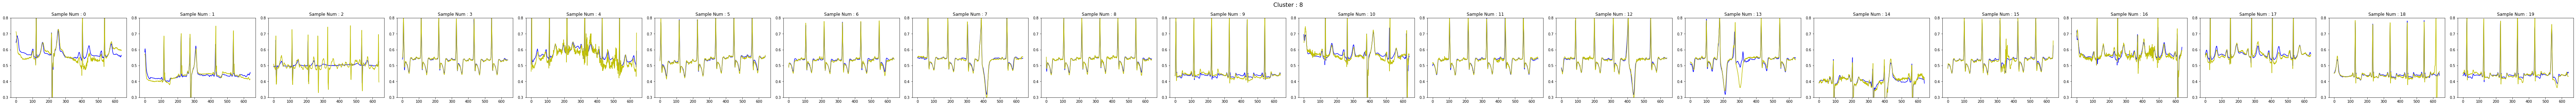

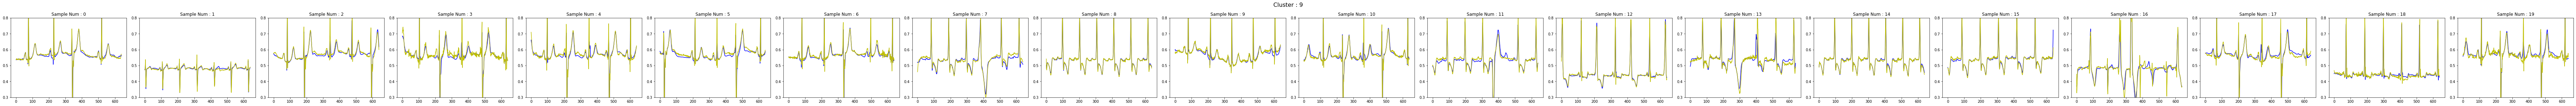

In [15]:
for i in range(len(np.unique(kmeans_latent.labels_))):
    sample = for_see[kmeans_latent.labels_ == i]
    sample = sample[np.random.permutation(len(sample))[:20]]
    sample = tf.convert_to_tensor(sample, dtype=tf.float32)
    outputs, latents, _ = model(sample)
    outputs = outputs.numpy()
    sample = sample.numpy()
    fig = plt.figure(figsize=(len(outputs)*5,4), constrained_layout=True)
    axs = fig.subplots(1, len(outputs))
    for idx, ax in enumerate(axs):
        arr = outputs[idx].reshape(-1)
        real = sample[idx].reshape(-1)
        ax.plot(np.arange(len(arr)), arr, color="b")
        ax.plot(np.arange(len(real)), real, color="y")
        ax.set_title("Sample Num : {}".format(idx))
        ax.set(ylim=(0.3, 0.8))
    fig.suptitle('Cluster : {}'.format(i), fontsize=16)
    plt.show()

# Latent Space 조작

In [16]:
DL_input = tf.keras.Input(model.layers[4].input_shape[1:])
DL_model = DL_input
DL_model = model.layers[4](DL_model)
DL_model = tf.keras.Model(inputs=DL_input, outputs=DL_model)

DL_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
Decoder_Module (Functional)  (None, 640, 1)            5176001   
Total params: 5,176,001
Trainable params: 5,176,001
Non-trainable params: 0
_________________________________________________________________


In [18]:
find_idx = 5
now_idx = 0
for x in train_set_tensor:
    now_idx+=1
    if now_idx == find_idx:
        output, latent_arr, _ = model(x)
        break

In [20]:
sample_latent_arr = latent_arr.numpy()[10]
sample_latent_arr = sample_latent_arr.reshape(1,8)

sample_latent_tensor = tf.convert_to_tensor(sample_latent_arr, dtype=tf.float32)

# 기준 샘플 추출

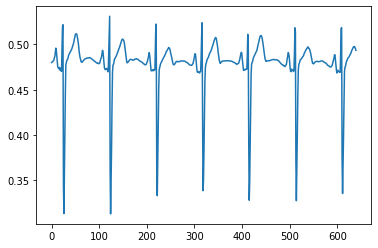

In [21]:
output_sampel = DL_model(sample_latent_tensor)
plt.plot(output_sampel.numpy().reshape(-1))

# Latent Vector 변경

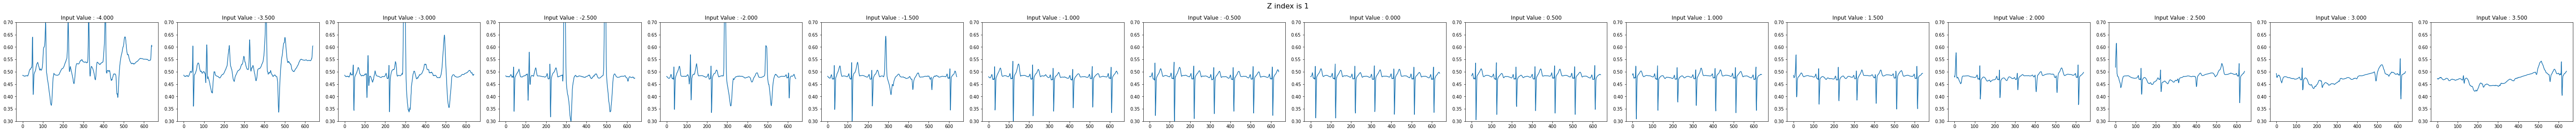

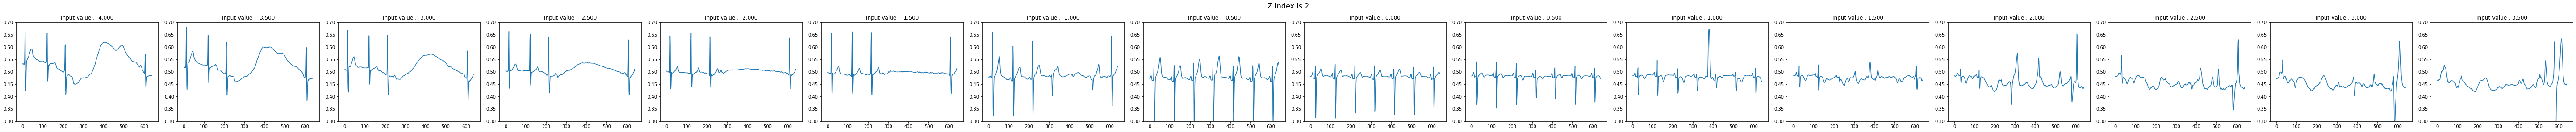

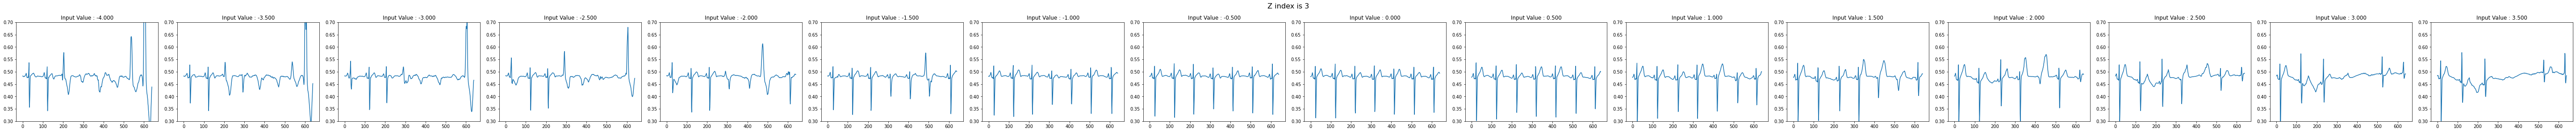

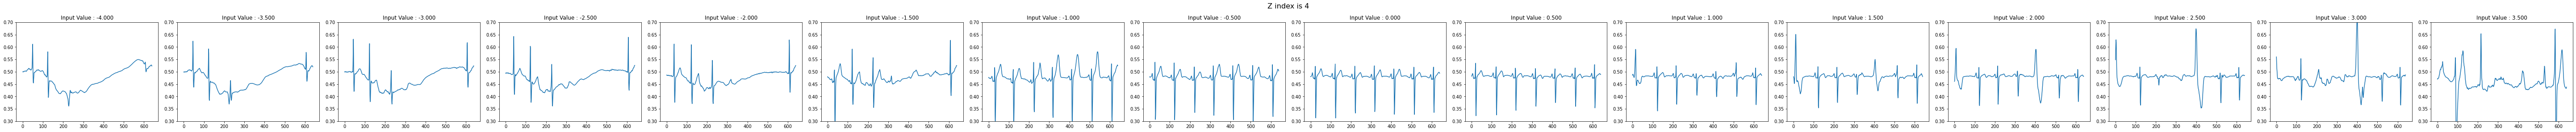

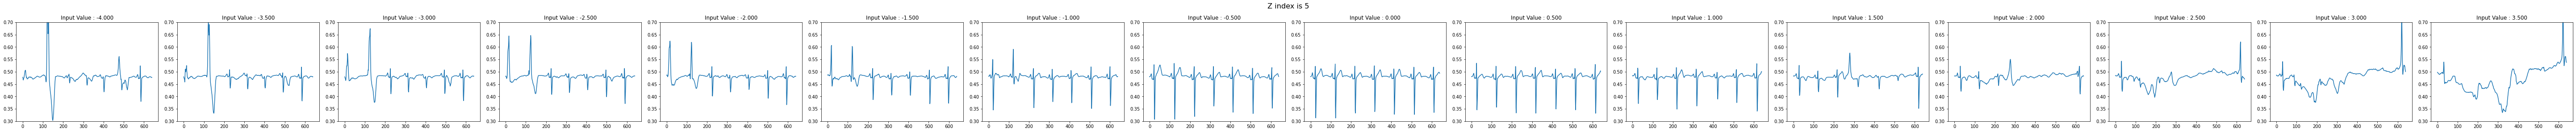

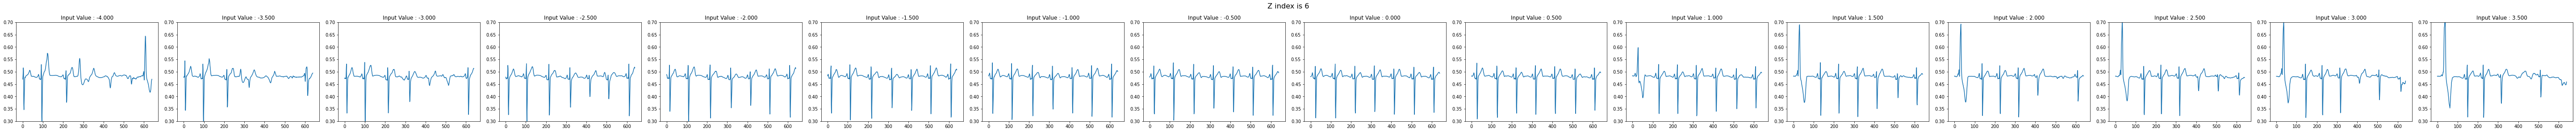

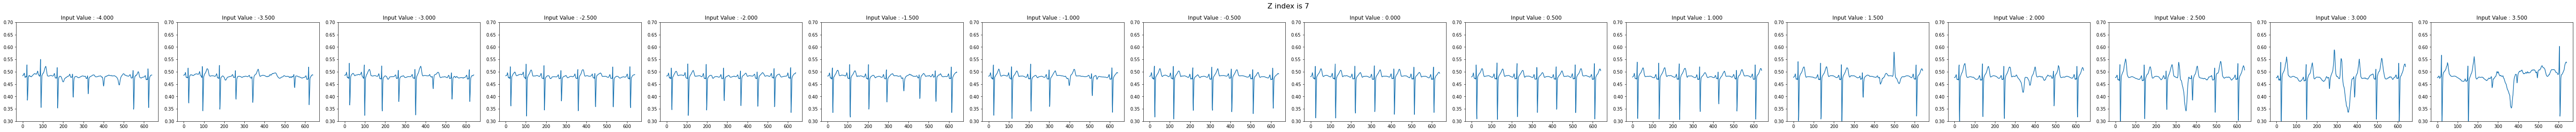

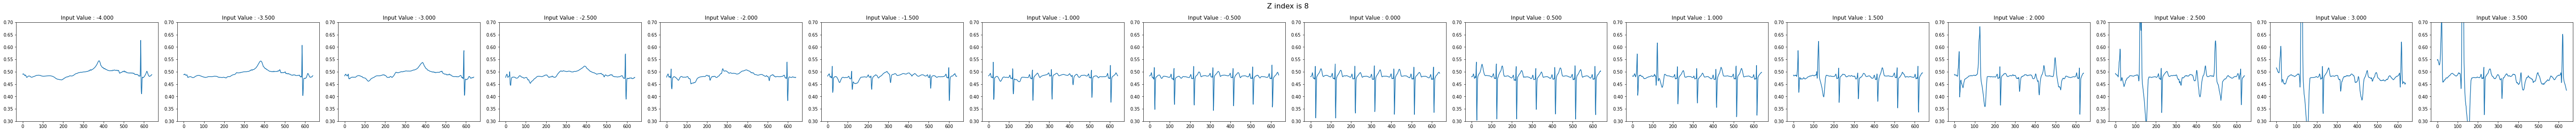

In [24]:
add_arr = np.arange(-4, 4, 0.5)

for z_idx in range(8):
    fig = plt.figure(figsize=(len(add_arr)*5,4), constrained_layout=True)
    axs = fig.subplots(1, len(add_arr))
    for idx, ax in enumerate(axs):
        for_input_mu = sample_latent_arr.copy()
        for_input_mu[:,z_idx] += add_arr[idx]
        outs = DL_model(for_input_mu).numpy().reshape(-1)
        ax.plot(np.arange(len(outs)), outs)
        ax.set_title("Input Value : {:.3f}".format(add_arr[idx]))
        ax.set(ylim=(0.3, 0.7))
    fig.suptitle('Z index is {}'.format(z_idx+1), fontsize=16)
    plt.show()